In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import batman, catwoman
from multiprocessing import Pool
import emcee


In [2]:
## some useful conversions
AU_to_meter = 1.496e11
day_to_second = 24.*60.*60.
Rsun_to_meter = 6.957e8
Rjup_to_meter = 7.149e7
Mjup_to_kg = 1.899e27

## handy calculations
def calc_impact_param(a_over_Rstar, inc):
    # assumes a circular orbit
    # Inputs:
    # a_over_Rstar = orbital semi-major-axis in units of stellar radii
    # inc = orbital inclination in [degrees]
    b = a_over_Rstar*np.cos(np.deg2rad(inc))
    return b
    
## functions to measure the points of transit contact
def get_T1_index(time, y):
    # get the index where T1 occurs
    # defined as where model flux first goes < 1
    pretransit_idxs = np.where((y == 1.0) & (time < np.median(time)))[0] # 'oot' indexes
    T1_idx = pretransit_idxs[-1] 
    return T1_idx
def get_T4_index(time, y):
    # get the index where T4 occurs
    # defined as where model flux last goes = 1
    posttransit_idxs = np.where((y == 1.0) & (time > np.median(time)))[0] # 'oot' indexes
    T4_idx = posttransit_idxs[0] 
    return T4_idx

## ANALYTIC FUNCTIONS
def predict_dT1(period, semi_maj_axis, impact_param, Rstar, Rmorning, Runiform):
    # Inputs:
    # period = orbital period in any time units, will just become the output unit
    # semi_maj_axis = orbital semi-major-axis in same units as the input radii parameters, as the length units cancel
    # impact_param = orbital impact parameter (w.r.t. stellar equator), unitless
    # Rstar = radius of the star
    # Rmorning = radius of the planet's morning-limb
    # Runiform = radius of the equivalent-depth uniform-limb planet
    prefactor = period / (2.*np.pi*semi_maj_axis)
    term1 = np.sqrt( (Rstar + Rmorning)**2 - (impact_param * Rstar)**2 )
    term2 = np.sqrt( (Rstar + Runiform)**2 - (impact_param * Rstar)**2 )
    calc = prefactor*(term1 - term2)
    return calc

def predict_dT4(period, semi_maj_axis, impact_param, Rstar, Revening, Runiform):
    # same calculation as deltaT1, but replace {Rmorning, Runiform} in dT1 calc with {Runiform, Revening} here
    calc = predict_dT1(period, semi_maj_axis, impact_param, Rstar, Runiform, Revening)
    return calc

def overlap_compensation(Rp_ref, RpRstar, H, N, v_orb):
    ## Computes the expected additional dt that the
    ##   numerical model will use to compensate for
    ##   the overlap problem.
    ## INPUTS:
    ##   Rp_ref = smallest limb radius, in [meter]
    ##   RpRstar = planet-star radius ratio, corresponding to Rp_ref
    ##   H = planetary atmosphere bulk scale height in [meter]
    ##   N = number of scale heights btwn. Rp_ref and larger limb radius
    ##   v_orb = planet's orbital speed in [meters / second]
    ## OUTPUT: the expected compensation in [seconds]
    
    # Compute the x-coordinate i.e. the radius of the larger limb
    x = Rp_ref + (N*H) # [meter]f
    # Compute y i.e. the distance from the planet's central axis
    #   to the stellar disk edge
    y = (Rp_ref/RpRstar) - np.sqrt((Rp_ref/RpRstar)**2 - x**2) # [meter]
    # Convert to the duration of time from ... to ...
    ytime = y / v_orb # [s]
    return ytime

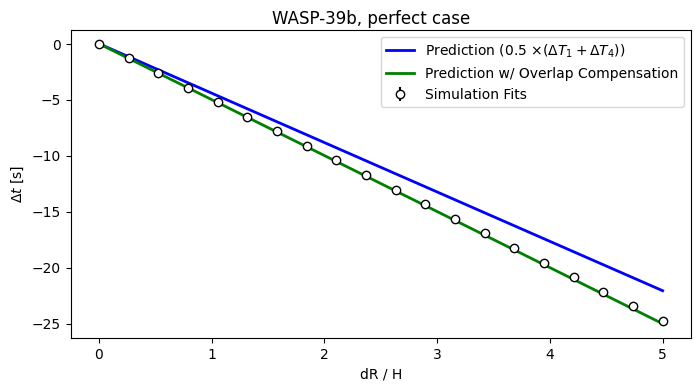

In [49]:
## -- load in numerical results

## -- WASP-39b 
## simulation results
w39_file = './newresults_perfectcase_wasp39b_uniformLD.npz'
w39_load = np.load(w39_file)
w39_Nvals = w39_load['Nvals']
w39_Hval = w39_load['Hval'] # scale height in [meter]
w39_time = w39_load['time_axis']
w39_true_lightcurves = w39_load['true_lightcurves']
w39_bestfit_lightcurves = w39_load['bestfit_lightcurves']
w39_dt_fits = w39_load['dt_fits']
w39_dt_errs = w39_load['dt_fiterrs']
## planet parameters
w39_period_days = 4.0552941 # [day]
w39_a_Rstar = 11.55         # [stellar (wasp-39) radii]
w39_inc_deg = 87.32         # [degrees]
w39_Rstar_Rsol = 0.92868    # [Rsun]
w39_Rstar_meter = w39_Rstar_Rsol * Rsun_to_meter # [meter]
w39_a_meter = w39_a_Rstar * w39_Rstar_Rsol * Rsun_to_meter
w39_impactparam = calc_impact_param(w39_a_Rstar, w39_inc_deg) # [unitless]
w39_Rpref_meter = 0.1457 * w39_Rstar_Rsol * Rsun_to_meter # [meters], this is the 'starting' radius for the evening-limb radii values
w39_Rpeve_vals_meter = w39_Rpref_meter*np.ones(len(w39_Nvals))
w39_dR_vals_meter = w39_Nvals * w39_Hval
w39_Rpmorn_vals_meter = w39_Rpeve_vals_meter + w39_dR_vals_meter
w39_Rpunif_vals_meter = np.sqrt(0.5*(w39_Rpeve_vals_meter**2 + w39_Rpmorn_vals_meter**2))
w39_vorb = (2.*np.pi*w39_a_meter) / (w39_period_days*24.*60.*60.) # [m/s]
## calculate analytic stuff to compare
w39_predicted_dT1self_vals_sec = predict_dT1(w39_period_days, w39_a_meter, w39_impactparam, w39_Rstar_meter, w39_Rpmorn_vals_meter, w39_Rpeve_vals_meter)*day_to_second
w39_predicted_dT4self_vals_sec = predict_dT4(w39_period_days, w39_a_meter, w39_impactparam, w39_Rstar_meter, w39_Rpeve_vals_meter, w39_Rpeve_vals_meter)*day_to_second
w39_predicted_dT1ucase_vals_sec = predict_dT1(w39_period_days, w39_a_meter, w39_impactparam, w39_Rstar_meter, w39_Rpmorn_vals_meter, w39_Rpunif_vals_meter)*day_to_second
w39_predicted_dT4ucase_vals_sec = predict_dT4(w39_period_days, w39_a_meter, w39_impactparam, w39_Rstar_meter, w39_Rpeve_vals_meter, w39_Rpunif_vals_meter)*day_to_second
w39_predicted_dt = -0.5*(w39_predicted_dT1ucase_vals_sec+w39_predicted_dT4ucase_vals_sec)
w39_overlapcomp_sec = 0.5*overlap_compensation(w39_Rpref_meter, (w39_Rpref_meter/w39_Rstar_meter), w39_Hval, w39_Nvals, w39_vorb)
w39_overlapcomp_sec -= w39_overlapcomp_sec[0]

## plot results -- timing bias
fig, ax = plt.subplots(figsize=(8,4))
fig.suptitle('WASP-39b, perfect case',y=0.93)
ax.errorbar(w39_Nvals, w39_dt_fits, w39_dt_errs, marker='o', ls='None', c='black', mfc='white', label='Simulation Fits')
ax.plot(w39_Nvals, w39_predicted_dt, lw=2, c='blue', label=r'Prediction (0.5 $\times \left( \Delta T_1 + \Delta T_4\right)$)')
ax.plot(w39_Nvals, w39_predicted_dt-w39_overlapcomp_sec, lw=2, c='green', label='Prediction w/ Overlap Compensation')
ax.set(xlabel='dR / H', ylabel=r'$\Delta t$ [s]')
ax.legend(loc='best')
plt.show()

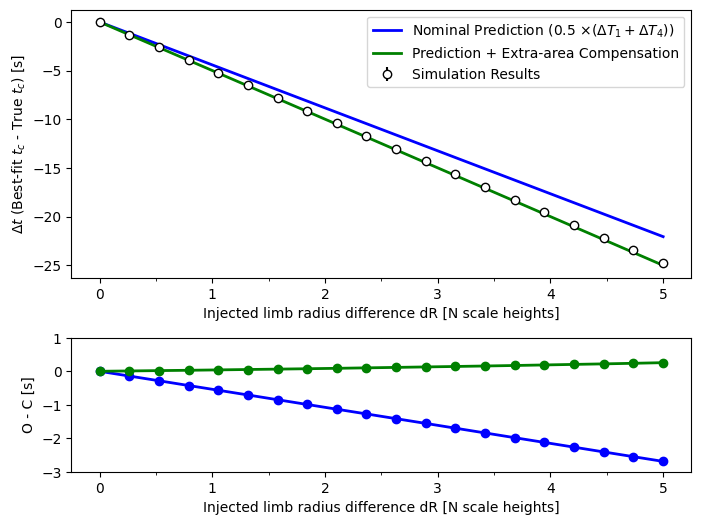

In [64]:
## plot results -- timing bias
fig, ax = plt.subplots(figsize=(8,6), nrows=2, gridspec_kw={'height_ratios':[2,1]})
plt.subplots_adjust(hspace=0.3)
#fig.suptitle('WASP-39b, perfect case',y=0.93)
ax[0].errorbar(w39_Nvals, w39_dt_fits, w39_dt_errs, marker='o', ls='None', c='black', mfc='white', label='Simulation Results')
ax[0].plot(w39_Nvals, w39_predicted_dt, lw=2, c='blue', label=r'Nominal Prediction (0.5 $\times \left( \Delta T_1 + \Delta T_4\right)$)')
ax[0].plot(w39_Nvals, w39_predicted_dt-w39_overlapcomp_sec, lw=2, c='green', label='Prediction + Extra-area Compensation')
ax[0].set_xlabel('Injected limb radius difference dR [N scale heights]')
ax[0].set_ylabel(r'$\Delta t$ (Best-fit $t_c$ - True $t_c$) [s]')
ax[0].legend(loc='best')
ax[0].xaxis.set_major_locator(MultipleLocator(1))
ax[0].xaxis.set_minor_locator(MultipleLocator(0.5))

blue_OC = (w39_dt_fits - w39_predicted_dt)
green_OC = (w39_dt_fits - (w39_predicted_dt-w39_overlapcomp_sec))
ax[1].plot(w39_Nvals, blue_OC, lw=2, c='blue', marker='o')
ax[1].plot(w39_Nvals, green_OC, lw=2, c='green', marker='o')
ax[1].set_xlabel('Injected limb radius difference dR [N scale heights]')
ax[1].set_ylabel('O - C [s]')
ax[1].set(ylim=(-3,1))
ax[1].xaxis.set_major_locator(MultipleLocator(1))
ax[1].xaxis.set_minor_locator(MultipleLocator(0.5))
plt.savefig('./paper_figures/perfectLC_fitvstruth_tcbias.png', bbox_inches='tight', dpi=400)
plt.savefig('./paper_figures/perfectLC_fitvstruth_tcbias.pdf', bbox_inches='tight', dpi=400, format='pdf')
plt.show()

Looking at the "perfect case" based on WASP-39b parameters to evaluate how the overall theory stacks up.

In [44]:
## -- track how T1 and T4 changed in the numerical sim's true light curves
## -- this assumes that the first light curve is a reference, and has N = 0
day_to_second = 60.*60.*24.

T1_fromtrueLCs = np.zeros(len(w39_Nvals)) 
T4_fromtrueLCs = np.zeros(len(w39_Nvals))
T1_frombfLCs = np.zeros(len(w39_Nvals)) 
T4_frombfLCs = np.zeros(len(w39_Nvals))
for iN, N in enumerate(w39_Nvals):
    # numerically determine T1 and T4 of each "true" lightcurve
    T1_fromtrueLCs[iN] = w39_time[get_T1_index(w39_time, w39_true_lightcurves[iN,:])] # [day]
    T4_fromtrueLCs[iN] = w39_time[get_T4_index(w39_time, w39_true_lightcurves[iN,:])] # [day]
    # numerically determine T1 and T4 of each best-fit lightcurve
    T1_frombfLCs[iN] = w39_time[get_T1_index(w39_time, w39_bestfit_lightcurves[iN,:])] # [day]
    T4_frombfLCs[iN] = w39_time[get_T4_index(w39_time, w39_bestfit_lightcurves[iN,:])] # [day]
# calculate change in T1 and T4 just of asymmetric-limb planet w.r.t initial state, assuming first value in arrays are the reference
dT1_fromtrueLCs = (T1_fromtrueLCs - T1_fromtrueLCs[0]) # [day]
dT4_fromtrueLCs = (T4_fromtrueLCs - T4_fromtrueLCs[0]) # [day]
# calculate change in T1 and T4 btwn. asymmetric-limb planet LC (truth) and the best-fit equiv. uniform-limb planet (with shifted Tc)
#       as function of asymmetry increasing. shouldn't follow analytic prediction! should be small, but non-zero
dT1_bf_from_true = (T1_frombfLCs - T1_fromtrueLCs) # [day]
dT4_bf_from_true = (T4_frombfLCs - T4_fromtrueLCs) # [day]



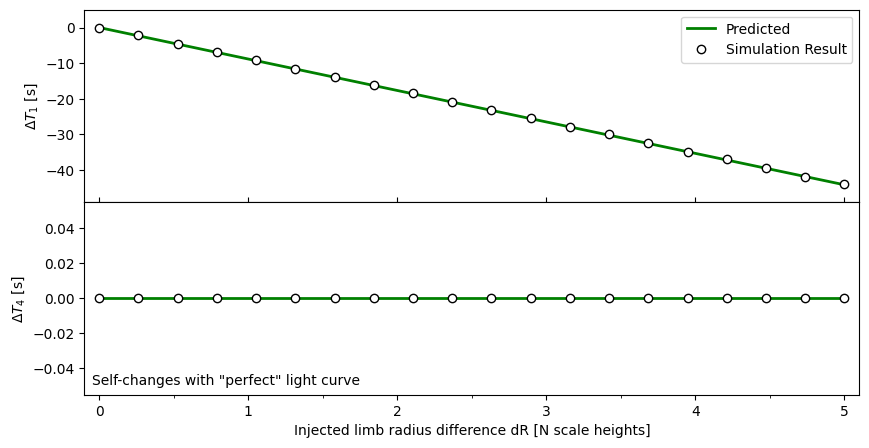

In [43]:
# plot these changes
# note these are NOT changes in T1, T4 btwn. asym-limb planet and the equivalent planet
# these are changes in T1, T4 just for the asym-limb planet w.r.t. the starting case as the asymmetry increases
fig, ax = plt.subplots(figsize=(10,5), nrows=2, sharex=True)
#fig.suptitle('Self-changes in contact time of asymmetric-limb planet w.r.t. initial condition', y=0.93)
plt.subplots_adjust(hspace=0.)
ax[0].plot(w39_Nvals, -w39_predicted_dT1self_vals_sec, c='green', ls='solid', lw=2, label='Predicted')
ax[0].plot(w39_Nvals, dT1_fromtrueLCs*day_to_second, marker='o', ls='None', mec='black', mfc='white', label='Simulation Result')
ax[0].set_ylabel('$\Delta T_1$ [s]')
ax[0].legend(loc='upper right')
ax[0].tick_params(axis='x', direction='in')
ax[0].xaxis.set_major_locator(MultipleLocator(1))
ax[0].xaxis.set_minor_locator(MultipleLocator(0.5))
ax[0].set(ylim=(-49,5))

ax[1].plot(w39_Nvals, -w39_predicted_dT4self_vals_sec, c='green', ls='solid', lw=2)
ax[1].plot(w39_Nvals, dT4_fromtrueLCs*day_to_second, marker='o', ls='None', mec='black', mfc='white')
ax[1].set_ylabel('$\Delta T_4$ [s]')
ax[1].set_xlabel('Injected limb radius difference dR [N scale heights]')
ax[1].xaxis.set_major_locator(MultipleLocator(1))
ax[1].xaxis.set_minor_locator(MultipleLocator(0.5))
ax[1].set(xlim=(-0.1,5.1))
ax[1].text(0.01, 0.05, 'Self-changes with "perfect" light curve', transform=ax[1].transAxes)
plt.savefig('./paper_figures/perfectLC_selfchanges_T1andT4.png', bbox_inches='tight', dpi=400)
plt.savefig('./paper_figures/perfectLC_selfchanges_T1andT4.pdf', bbox_inches='tight', dpi=400, format='pdf')
plt.show()

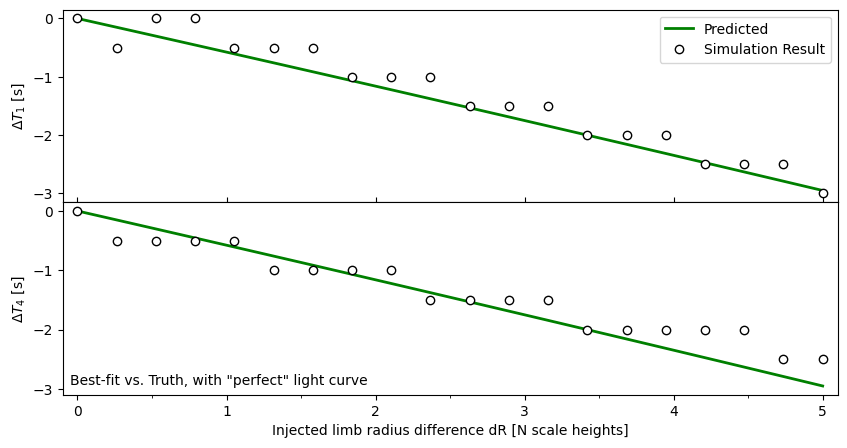

In [48]:
## -- note the following is to be compared to analytical prediction of the extra-area comp.
#  results with a shifted tc, not the same tc as the true asym-limb model
fig, ax = plt.subplots(figsize=(10,5), nrows=2, sharex=True)
#fig.suptitle('Changes in contact time of true LC vs. best-fit LC (with shifted t$_c$)', y=0.93)
plt.subplots_adjust(hspace=0.)
ax[0].plot(w39_Nvals, -w39_overlapcomp_sec, c='green', ls='solid', lw=2, label='Predicted')
ax[0].plot(w39_Nvals, dT1_bf_from_true*day_to_second, marker='o', ls='None', mec='black', mfc='white', label='Simulation Result')
ax[0].set_ylabel('$\Delta T_1$ [s]')
ax[0].legend(loc='upper right')
ax[0].tick_params(axis='x', direction='in')
ax[0].xaxis.set_major_locator(MultipleLocator(1))
ax[0].xaxis.set_minor_locator(MultipleLocator(0.5))
#ax[0].set(ylim=(-49,5))

ax[1].plot(w39_Nvals, -w39_overlapcomp_sec, c='green', ls='solid', lw=2)
ax[1].plot(w39_Nvals, dT4_bf_from_true*day_to_second, marker='o', ls='None', mec='black', mfc='white')
ax[1].set_ylabel('$\Delta T_4$ [s]')
ax[1].set_xlabel('Injected limb radius difference dR [N scale heights]')
ax[1].xaxis.set_major_locator(MultipleLocator(1))
ax[1].xaxis.set_minor_locator(MultipleLocator(0.5))
ax[1].set(xlim=(-0.1,5.1))
ax[1].text(0.01, 0.05, 'Best-fit vs. Truth, with "perfect" light curve', transform=ax[1].transAxes)
plt.savefig('./paper_figures/perfectLC_fitvstruth_T1andT4.png', bbox_inches='tight', dpi=400)
plt.savefig('./paper_figures/perfectLC_fitvstruth_T1andT4.pdf', bbox_inches='tight', dpi=400, format='pdf')
plt.show()

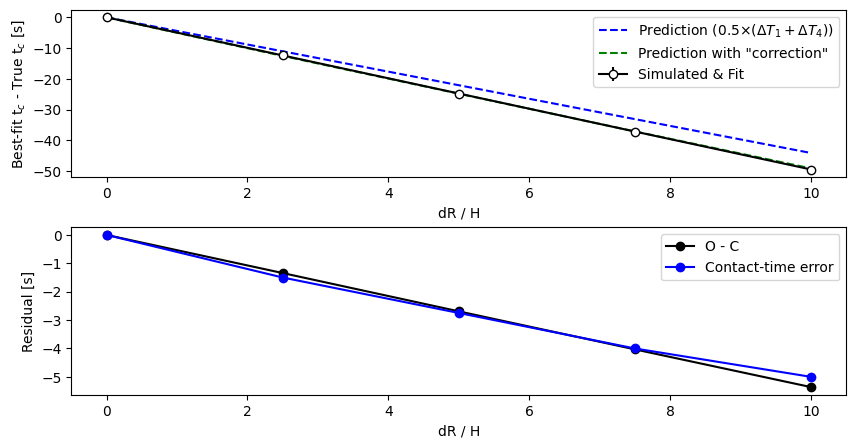

In [6]:
## -- see the best-fit timing bias
dt_prediction = -0.5*(w39_predicted_dT1ucase_vals_sec + w39_predicted_dT4ucase_vals_sec)
O_minus_C = (w39_dt_fits - dt_prediction)
contact_err_correction = np.median((dT1_bf_from_true, dT4_bf_from_true), axis=0) * day_to_second

fig, ax = plt.subplots(figsize=(10,5), nrows=2)
plt.subplots_adjust(hspace=0.3)
ax[0].errorbar(w39_Nvals, w39_dt_fits, w39_dt_errs, marker='o', c='black', mfc='white', label='Simulated & Fit')
ax[0].plot(w39_Nvals, dt_prediction, c='blue', ls='--', label=r'Prediction (0.5$\times \left( \Delta T_1 + \Delta T_4 \right)$)')
ax[0].plot(w39_Nvals, dt_prediction+contact_err_correction, c='green', ls='--', label=r'Prediction with "correction"')
ax[0].set_xlabel('dR / H')
ax[0].set_ylabel('Best-fit t$_c$ - True t$_c$ [s]')
ax[0].legend(loc='best')
ax[1].plot(w39_Nvals, O_minus_C, marker='o', c='black', label='O - C')
ax[1].plot(w39_Nvals, contact_err_correction, marker='o', c='blue', label='Contact-time error')
ax[1].set_xlabel('dR / H')
ax[1].set_ylabel('Residual [s]')
ax[1].legend(loc='best')
plt.show()

In [7]:
print('N       dt fit')
for iN, N in enumerate(w39_Nvals):
    print('%.2f    %.2f'%(N, w39_dt_fits[iN]))

N       dt fit
0.00    -0.00
2.50    -12.38
5.00    -24.75
7.50    -37.10
10.00    -49.43


In [8]:
## -- why is there a contact time error ???


In [9]:
# hypothesis 1 -- the batman model can't get the right transit duration
# define transit duration as T4 - T1, with T1,T4 determined via my functions
true_durations = (T4_fromtrueLCs - T1_fromtrueLCs)*day_to_second # in [s]
batman_durations = (T4_frombfLCs - T1_frombfLCs)*day_to_second # in [s]
duration_diffs = (batman_durations - true_durations)

for iN, N in enumerate(w39_Nvals):
    print('='*20)
    print('N = %.2f'%(N))
    print('true duration = %.2f s'%(true_durations[iN]))
    print('fitted LC duration = %.2f s'%(batman_durations[iN]))
    print(' fitted value is %.2f s behind truth'%(duration_diffs[iN]))
    print(' predicted error here was %.2f s behind truth'%(-contact_err_correction[iN]))

N = 0.00
true duration = 9781.00 s
fitted LC duration = 9781.00 s
 fitted value is 0.00 s behind truth
 predicted error here was -0.00 s behind truth
N = 2.50
true duration = 9803.00 s
fitted LC duration = 9803.00 s
 fitted value is 0.00 s behind truth
 predicted error here was 1.50 s behind truth
N = 5.00
true duration = 9825.00 s
fitted LC duration = 9825.50 s
 fitted value is 0.50 s behind truth
 predicted error here was 2.75 s behind truth
N = 7.50
true duration = 9847.50 s
fitted LC duration = 9848.50 s
 fitted value is 1.00 s behind truth
 predicted error here was 4.00 s behind truth
N = 10.00
true duration = 9869.50 s
fitted LC duration = 9871.50 s
 fitted value is 2.00 s behind truth
 predicted error here was 5.00 s behind truth


In [10]:
# hypothesis 2 -- it has to do with the shapes of ingress/egress, and our fitting metrics
#   the asymmetric-limb models have a "notch" during ingress and egress due to the way the occulting
#       area "jumps" as the second semi-circle makes first contact
#   the uniform-limb model does not have this
#   I hypothesize that this notch throws off some fitting metric, e.g. the chi2 calculation in the likelihood
#      forcing it to find a slightly alternate solution that prioritizes minimizing the chi2 (or residual)
#      rather than getting the right start/end of transit


In [12]:
# fig, ax = plt.subplots(figsize=(10,10), nrows=2, sharex=True)
# plt.subplots_adjust(hspace=0.1)
# day_to_second = 24.*60.*60.
# iLC = 4
# this_T1 = T1_fromtrueLCs[iLC]*day_to_second
# this_bfT1 = T1_frombfLCs[iLC]*day_to_second
# ws = 30.
# voffset = 0.00025


# ax[0].axvline(this_T1, c='gray', lw=0.5, label=r'T$_{1, true~lc}$')
# ax[0].axvline(this_bfT1, c='green', lw=0.5, label=r'$T_{1, bf~lc}$')
# #ax[0].axvline(this_T1-6.0, c='blue', lw=0.5)
# ax[0].plot(w39_time*day_to_second, w39_true_lightcurves[iLC,:], lw=1, c='black', label='Truth (a.l. model)')
# #ax[0].plot(w39_time*day_to_second, w39_bestfit_lightcurves[iLC,:]+voffset, lw=0.5, c='green', label='Best-fit u.l. model')
# ax[0].set(ylabel='Relative flux', xlabel='Time')
# ax[0].legend(loc='best')

# bf_min_true =  (w39_bestfit_lightcurves[iLC,:] - w39_true_lightcurves[iLC,:])*1.e6
# ax[1].axvline(this_T1, c='gray', lw=0.5, label=r'T$_{1, true~lc}$')
# ax[1].axvline(this_bfT1, c='green', lw=0.5, label=r'$T_{1, bf~lc}$')
# ax[1].axvline(this_T1-5.0, c='blue', lw=0.5)
# ax[1].plot(w39_time*day_to_second, bf_min_true, c='black')
# ax[1].set(ylabel='O-C [ppm]', xlabel='Time')
# ax[1].legend(loc='best')

# #ax[0].set(ylim=(999.5, 1000.1))
# ax[1].set(xlim=(this_T1-ws, this_T1+ws), ylim=(-40,10))
# plt.show()

# print('mean residual = ', np.mean(bf_min_true))

In [13]:
## hyp3


In [30]:
# define p = Rp/Rstar
p = w39_Rpref_meter / w39_Rstar_meter
xRp = w39_Rpref_meter


xtests = (xRp + (w39_Nvals*w39_Hval))#/xRp
y = (xRp/p) - np.sqrt((xRp/p)**2 - xtests**2) # [meter]

#y_s = y/v # [s]

y_s = overlap_compensation(xRp, p, w39_Hval, w39_Nvals, v)
print(y_s-y_s[0])

[ 0.          2.9084283   5.89811606  8.96921615 12.12188601]


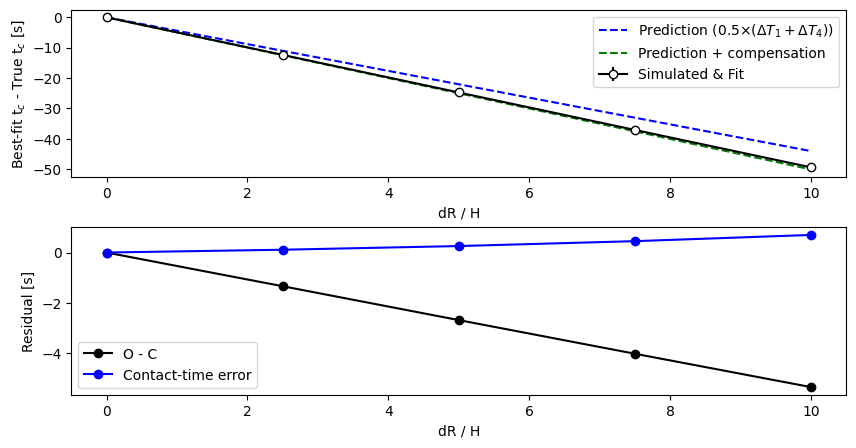

In [23]:
## -- see the best-fit timing bias
dt_prediction = -0.5*(w39_predicted_dT1ucase_vals_sec + w39_predicted_dT4ucase_vals_sec)
overlap_comp = -0.5*(y_s - y_s[0]) # not sure why this needs to be halved ...

O_minus_C = (w39_dt_fits - dt_prediction)
O_minus_C_withcomp = (w39_dt_fits - (dt_prediction+overlap_comp))

fig, ax = plt.subplots(figsize=(10,5), nrows=2)
plt.subplots_adjust(hspace=0.3)
ax[0].errorbar(w39_Nvals, w39_dt_fits, w39_dt_errs, marker='o', c='black', mfc='white', label='Simulated & Fit')
ax[0].plot(w39_Nvals, dt_prediction, c='blue', ls='--', label=r'Prediction (0.5$\times \left( \Delta T_1 + \Delta T_4 \right)$)')
ax[0].plot(w39_Nvals, dt_prediction+overlap_comp, c='green', ls='--', label=r'Prediction + compensation')
ax[0].set_xlabel('dR / H')
ax[0].set_ylabel('Best-fit t$_c$ - True t$_c$ [s]')
ax[0].legend(loc='best')
ax[1].plot(w39_Nvals, O_minus_C, marker='o', c='black', label='O - C')
ax[1].plot(w39_Nvals, O_minus_C_withcomp, marker='o', c='blue', label='Contact-time error')
ax[1].set_xlabel('dR / H')
ax[1].set_ylabel('Residual [s]')
ax[1].legend(loc='best')
plt.show()

In [ ]:
## note -- need to consider how to describe this "correction"
##  I think it's not an err to the formula, but rather a difference between the theory and what can be done in practice
##   i.e. we may be predicting the right thing, but through the models and *fitting* these models, the *thing* we measure
##      as our "best-fit" result is a different *quantity* than what our theory is making predictions on
##    and this "correction" is an idea for the difference between them, which seems to get fairly close.
##  Our theory predicts what dt is needed to get the contact points to rematch
##    because we're measuring goodness-of-fit by some metric related to minimized residuals, and the models have intrinsically
##    different shapes ... this dt is not necessarily the dt that will provide the best goodness-of-fit
##    and this correction is an attempt at explaining, and "un-doing" the way that it strays
##  This solution posits that the fit gets "led astray" b/c it compensates for the increased residual due to this overlap problem
##    and this "correction" is just a formulation of the time difference caused by this overlap, which the fit is adding on to itself
##    so by either adding this onto the theory prediction, or subtracting from the fit, we bring theory and fit into agreement.